In [1]:
from utils.load_dataset import *
from utils.custom_utils import *

In [2]:
model_path_var = "./models/checkpoint_train_virtual_and_real.pth"
model_path_vtr = "./models/checkpoint_train_real_over_virtual.pth"
model_path_r = "./models/checkpoint_train_real.pth"
model_path_v = "./models/checkpoint_train_virtual.pth"

In [3]:
def load_model(path):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    # create a Faster R-CNN model without pre-trained
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=False)

    num_classes = 3 # wheat or not(background)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # replace the pre-trained model's head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    checkpoint = torch.load(path, map_location=device)
    model.load_state_dict(checkpoint['model'])
    # load the trained weights
    #model.load_state_dict(torch.load(path, map_location=device))
    model.eval()

    # move model to the right device
    model.to(device)
    return model, device

In [4]:
def take_prediction(prediction, threshold):
    boxes = prediction['boxes'].tolist()
    labels = prediction['labels'].tolist()
    scores = prediction['scores'].tolist()
    if len(boxes) == 0:
        return [([0,0,0,0],1,0.)]
    
    res = [t for t in zip(boxes,labels,scores) if t[2]>threshold]
    if len(res) == 0:
        res = [([0,0,0,0],1,0.)]
    return res

In [5]:
def visualize_prediction(dataset, list_imgs, model, device, path=None, thr=0.7):
    for l in list_imgs:
        img,target = dataset[l]
        with torch.no_grad():
            prediction = model([img.to(device)])
        p = take_prediction(prediction[0],thr)
        for bb,label,score in p:
            if label == 1:
                color = "green"
                text = f"no fallen: {score:.3f}"
            else:
                color = "red"
                text = f"fallen: {score:.3f}"
            x0,y0,x1,y1 = bb
            im = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
            draw = ImageDraw.Draw(im)
            draw.rectangle(((x0, y0),(x1,y1)), outline=color, width=3)
            draw.text((x0, y0), text)
        if path is None:
            ImageShow.show(im)
        else:
            im.save(f'snapshots/{path}{l}.png')

In [6]:
def classifier_performance(dataset, model, device, fallen_or_not, tr = 0.7):
    tn, tp, fn, fp = 0,0,0,0
    for im,target in tqdm(dataset):
        gt_labels = target['labels'].tolist()
        with torch.no_grad():
            prediction = model([im.to(device)])
        p = take_prediction(prediction[0], tr)
        pred_labels = [l for _,l,_ in p]
        len_gt_lab = len(gt_labels)
        len_pred_lab = len(pred_labels)
        fall_gt = [i for i in gt_labels if i==fallen_or_not]
        num_fall_gt = len(fall_gt)
        num_no_fall_gt = len_gt_lab - num_fall_gt

        fall_pred = [i for i in pred_labels if i==fallen_or_not] 
        num_fall_pred = len(fall_pred)
        num_no_fall_pred = len_pred_lab - num_fall_pred

        if num_fall_gt == num_fall_pred:
            tp += num_fall_gt
        elif num_fall_gt > num_fall_pred:
            tp += num_fall_pred
            fn += (num_fall_gt - num_fall_pred)
        else:
            tp += num_fall_gt
            fp += (num_fall_pred - num_fall_gt)
    return tp, fp, fn

# UP-FALL DETECTION

In [7]:
test_elderly = load_data("test_elderly_try.txt")
test_dataset = FallenPeople(test_elderly, "test_elderly", FallenPeople.valid_test_transform())

In [8]:
test_list = [random.randint(0,len(test_dataset)-1) for i in range(10)]

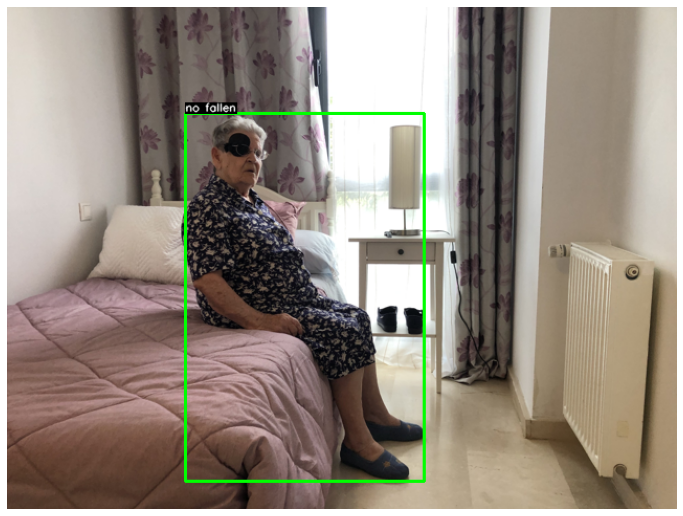

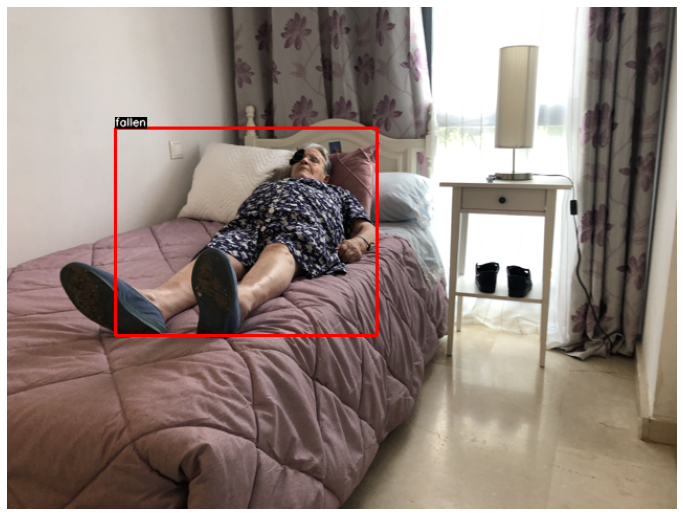

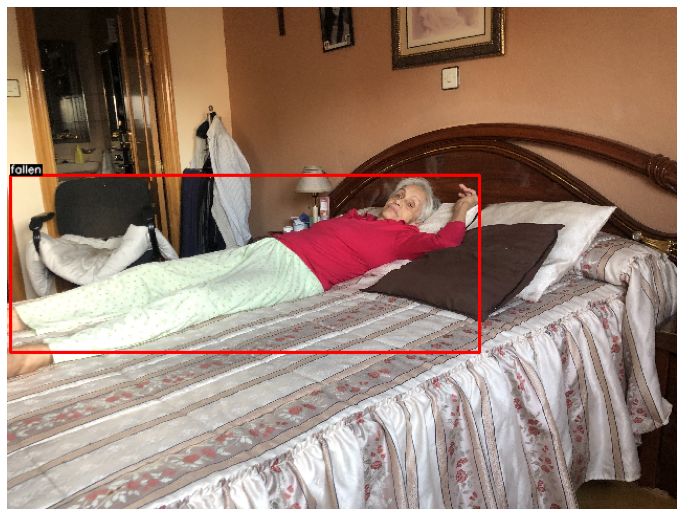

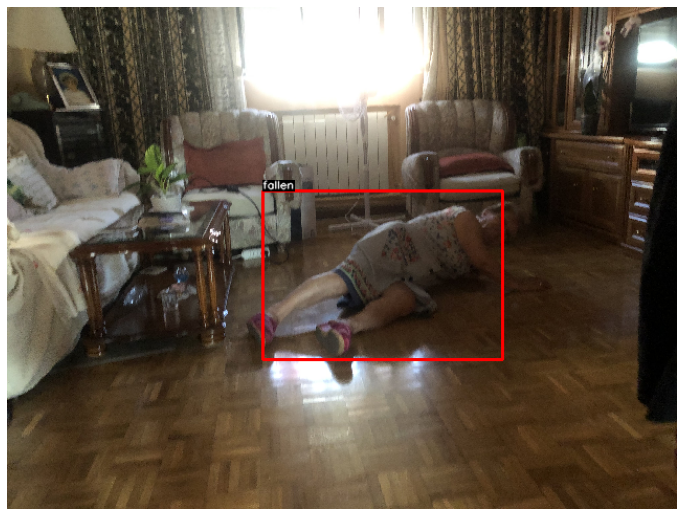

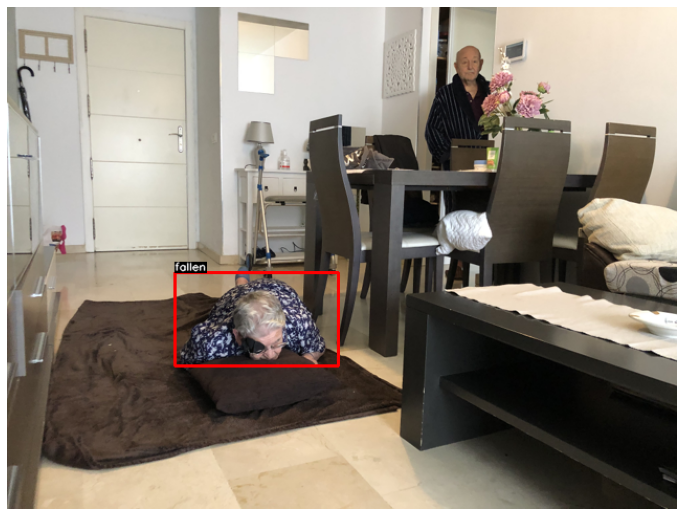

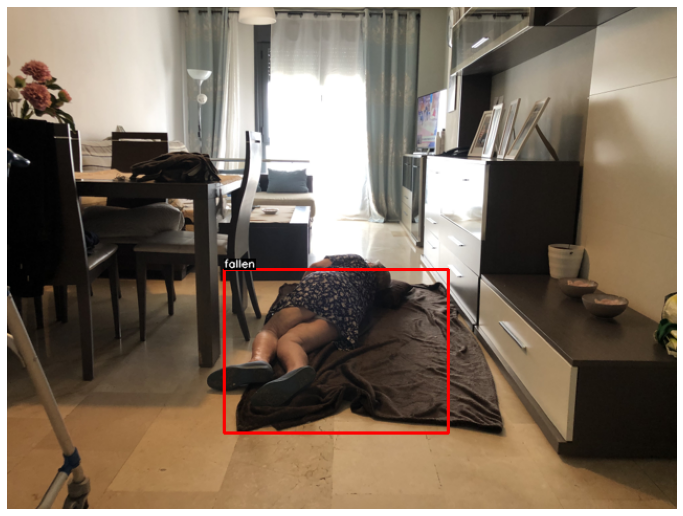

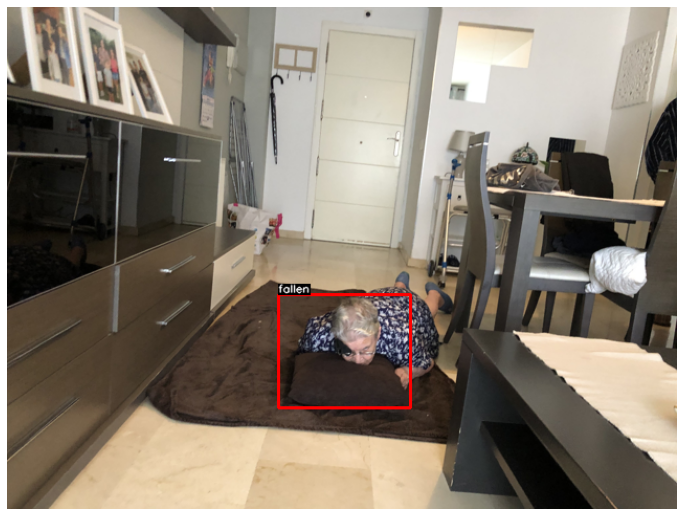

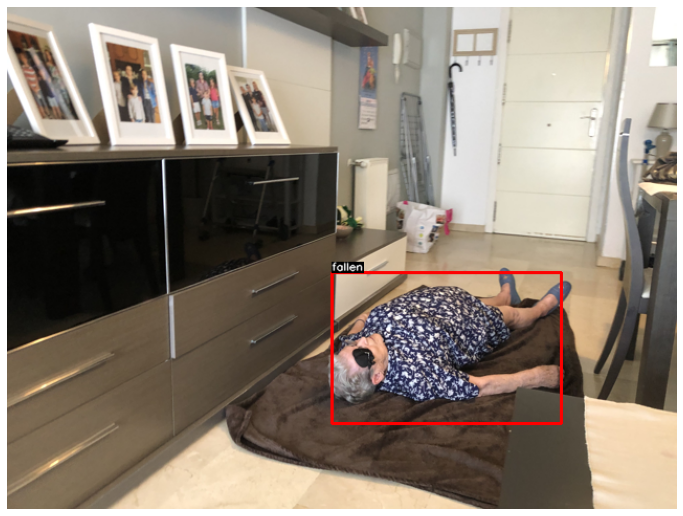

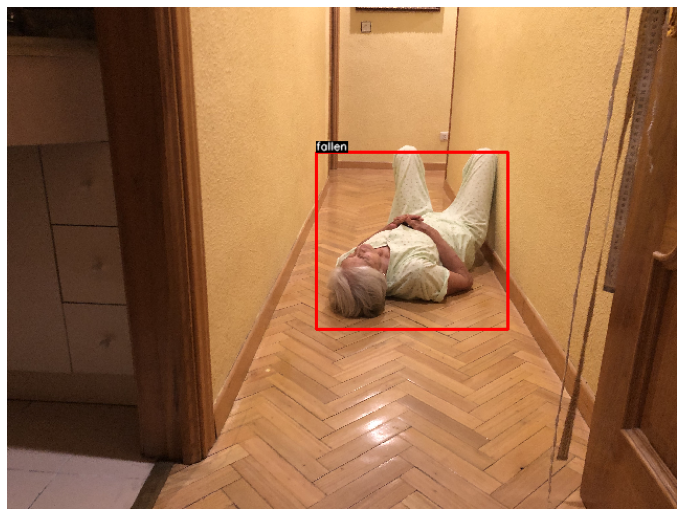

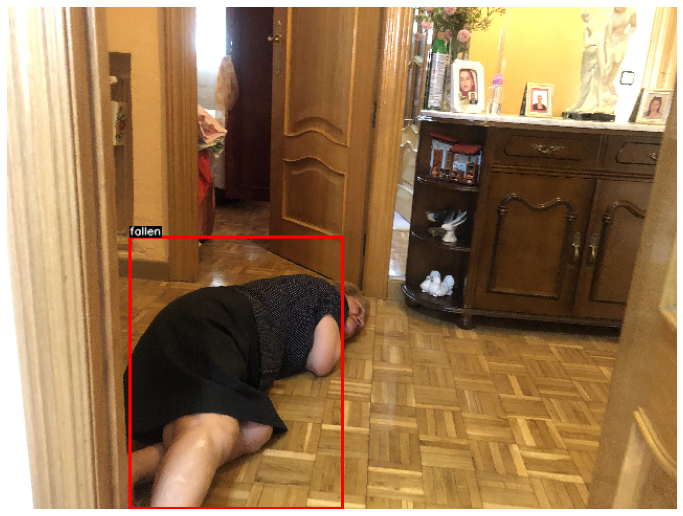

In [9]:
visualize_images_and_bb('test_elderly', test_elderly, test_list)

In [11]:
no_fall = 0
fall = 0
for t in test_dataset:
    if t[1]['labels'][0] == 1:
        no_fall += 1
    elif t[1]['labels'][0] == 2:
        fall += 1
print(no_fall)
print(fall)

55
357


In [12]:
def collate_fn(batch):
        return tuple(zip(*batch))
    
test_data_loader = DataLoader(
      test_dataset,
      batch_size=4,
      shuffle=False,
      collate_fn=collate_fn
    )

In [13]:
model_var, device = load_model(model_path_var)
model_vtr, _ = load_model(model_path_vtr)
model_r, _ = load_model(model_path_r)
model_v, _ = load_model(model_path_v)
test_list = [random.randint(0,len(test_dataset)-1) for i in range(5)]

# ONLY REAL

In [14]:
evaluate(model_r, test_data_loader, device=device)

creating index...
index created!
Test:  [  0/103]  eta: 0:00:40  model_time: 0.3374 (0.3374)  evaluator_time: 0.0043 (0.0043)  time: 0.3920  data: 0.0422  max mem: 2025
Test:  [100/103]  eta: 0:00:01  model_time: 0.3312 (0.3306)  evaluator_time: 0.0049 (0.0047)  time: 0.3959  data: 0.0561  max mem: 2025
Test:  [102/103]  eta: 0:00:00  model_time: 0.3309 (0.3306)  evaluator_time: 0.0049 (0.0047)  time: 0.3958  data: 0.0562  max mem: 2025
Test: Total time: 0:00:40 (0.3940 s / it)
Averaged stats: model_time: 0.3309 (0.3306)  evaluator_time: 0.0049 (0.0047)
Accumulating evaluation results...
DONE (t=0.11s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.236
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.559
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.135
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=me

### FALL DETECTION

In [15]:
recall, precision, f1_score = [],[],[]
for thr in range(0,10,1):
    tp, fp, fn = classifier_performance(test_dataset, model_r, device, 2,float(thr/10))
    rec = tp / (tp+fn)
    prec = tp/ (tp+fp)
    f1_s = 2/((1/rec)+(1/prec))
    recall.append(f"{rec:.2f}")
    precision.append(f"{prec:.2f}")
    f1_score.append(f"{f1_s:.2f}")
    print(f"TP: {tp}\tFN: {fn}\tFP: {fp}")
    print(f"Recall: {rec:.2f}")
    print(f"Precision: {prec:.2f}")
    print(f"F1-score: {f1_s:.2f}")

100%|██████████| 412/412 [00:43<00:00,  9.48it/s]


TP: 357	FN: 0	FP: 469
Recall: 1.00
Precision: 0.43
F1-score: 0.60


100%|██████████| 412/412 [00:44<00:00,  9.33it/s]


TP: 356	FN: 1	FP: 310
Recall: 1.00
Precision: 0.53
F1-score: 0.70


100%|██████████| 412/412 [00:44<00:00,  9.30it/s]


TP: 353	FN: 4	FP: 182
Recall: 0.99
Precision: 0.66
F1-score: 0.79


100%|██████████| 412/412 [00:44<00:00,  9.25it/s]


TP: 346	FN: 11	FP: 134
Recall: 0.97
Precision: 0.72
F1-score: 0.83


100%|██████████| 412/412 [00:44<00:00,  9.22it/s]


TP: 335	FN: 22	FP: 89
Recall: 0.94
Precision: 0.79
F1-score: 0.86


100%|██████████| 412/412 [00:44<00:00,  9.16it/s]


TP: 329	FN: 28	FP: 66
Recall: 0.92
Precision: 0.83
F1-score: 0.88


100%|██████████| 412/412 [00:44<00:00,  9.18it/s]


TP: 317	FN: 40	FP: 39
Recall: 0.89
Precision: 0.89
F1-score: 0.89


100%|██████████| 412/412 [00:45<00:00,  9.10it/s]


TP: 290	FN: 67	FP: 27
Recall: 0.81
Precision: 0.91
F1-score: 0.86


100%|██████████| 412/412 [00:45<00:00,  9.15it/s]


TP: 259	FN: 98	FP: 16
Recall: 0.73
Precision: 0.94
F1-score: 0.82


100%|██████████| 412/412 [00:44<00:00,  9.18it/s]

TP: 232	FN: 125	FP: 8
Recall: 0.65
Precision: 0.97
F1-score: 0.78


In [16]:
print(recall)
print(precision)
print(f1_score)

['1.00', '1.00', '0.99', '0.97', '0.94', '0.92', '0.89', '0.81', '0.73', '0.65']
['0.43', '0.53', '0.66', '0.72', '0.79', '0.83', '0.89', '0.91', '0.94', '0.97']
['0.60', '0.70', '0.79', '0.83', '0.86', '0.88', '0.89', '0.86', '0.82', '0.78']


### NO-FALL DETECTION

In [17]:
recall, precision, f1_score = [],[],[]
for thr in range(0,10,1):
    tp, fp, fn = classifier_performance(test_dataset, model_r, device, 1,float(thr/10))
    rec = tp / (tp+fn)
    prec = tp/ (tp+fp)
    f1_s = 2/((1/rec)+(1/prec))
    recall.append(f"{rec:.2f}")
    precision.append(f"{prec:.2f}")
    f1_score.append(f"{f1_s:.2f}")
    print(f"TP: {tp}\tFN: {fn}\tFP: {fp}")
    print(f"Recall: {rec:.2f}")
    print(f"Precision: {prec:.2f}")
    print(f"F1-score: {f1_s:.2f}")

100%|██████████| 412/412 [00:43<00:00,  9.45it/s]


TP: 65	FN: 0	FP: 1167
Recall: 1.00
Precision: 0.05
F1-score: 0.10


100%|██████████| 412/412 [00:44<00:00,  9.20it/s]


TP: 65	FN: 0	FP: 822
Recall: 1.00
Precision: 0.07
F1-score: 0.14


100%|██████████| 412/412 [00:44<00:00,  9.19it/s]


TP: 65	FN: 0	FP: 548
Recall: 1.00
Precision: 0.11
F1-score: 0.19


100%|██████████| 412/412 [00:45<00:00,  9.14it/s]


TP: 65	FN: 0	FP: 439
Recall: 1.00
Precision: 0.13
F1-score: 0.23


100%|██████████| 412/412 [00:45<00:00,  9.09it/s]


TP: 65	FN: 0	FP: 335
Recall: 1.00
Precision: 0.16
F1-score: 0.28


100%|██████████| 412/412 [00:45<00:00,  9.10it/s]


TP: 64	FN: 1	FP: 253
Recall: 0.98
Precision: 0.20
F1-score: 0.34


100%|██████████| 412/412 [00:44<00:00,  9.17it/s]


TP: 60	FN: 5	FP: 209
Recall: 0.92
Precision: 0.22
F1-score: 0.36


100%|██████████| 412/412 [00:44<00:00,  9.22it/s]


TP: 61	FN: 4	FP: 179
Recall: 0.94
Precision: 0.25
F1-score: 0.40


100%|██████████| 412/412 [00:45<00:00,  9.09it/s]


TP: 63	FN: 2	FP: 172
Recall: 0.97
Precision: 0.27
F1-score: 0.42


100%|██████████| 412/412 [00:44<00:00,  9.18it/s]

TP: 61	FN: 4	FP: 165
Recall: 0.94
Precision: 0.27
F1-score: 0.42


In [18]:
print(recall)
print(precision)
print(f1_score)

['1.00', '1.00', '1.00', '1.00', '1.00', '0.98', '0.92', '0.94', '0.97', '0.94']
['0.05', '0.07', '0.11', '0.13', '0.16', '0.20', '0.22', '0.25', '0.27', '0.27']
['0.10', '0.14', '0.19', '0.23', '0.28', '0.34', '0.36', '0.40', '0.42', '0.42']


## ONLY VIRTUAL

In [20]:
evaluate(model_v, test_data_loader, device=device)

creating index...
index created!
Test:  [  0/103]  eta: 0:00:38  model_time: 0.3215 (0.3215)  evaluator_time: 0.0067 (0.0067)  time: 0.3738  data: 0.0426  max mem: 2025
Test:  [100/103]  eta: 0:00:01  model_time: 0.3345 (0.3313)  evaluator_time: 0.0061 (0.0066)  time: 0.3988  data: 0.0552  max mem: 2025
Test:  [102/103]  eta: 0:00:00  model_time: 0.3345 (0.3313)  evaluator_time: 0.0061 (0.0066)  time: 0.3973  data: 0.0541  max mem: 2025
Test: Total time: 0:00:40 (0.3963 s / it)
Averaged stats: model_time: 0.3345 (0.3313)  evaluator_time: 0.0061 (0.0066)
Accumulating evaluation results...
DONE (t=0.13s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.246
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.491
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.195
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=me

### FALL DETECTION

In [21]:
recall, precision, f1_score = [],[],[]
for thr in range(0,10,1):
    tp, fp, fn = classifier_performance(test_dataset, model_v, device, 2,float(thr/10))
    rec = tp / (tp+fn)
    prec = tp/ (tp+fp)
    f1_s = 2/((1/rec)+(1/prec))
    recall.append(f"{rec:.2f}")
    precision.append(f"{prec:.2f}")
    f1_score.append(f"{f1_s:.2f}")
    print(f"TP: {tp}\tFN: {fn}\tFP: {fp}")
    print(f"Recall: {rec:.2f}")
    print(f"Precision: {prec:.2f}")
    print(f"F1-score: {f1_s:.2f}")

100%|██████████| 412/412 [00:44<00:00,  9.26it/s]


TP: 355	FN: 2	FP: 1527
Recall: 0.99
Precision: 0.19
F1-score: 0.32


100%|██████████| 412/412 [00:44<00:00,  9.22it/s]


TP: 351	FN: 6	FP: 777
Recall: 0.98
Precision: 0.31
F1-score: 0.47


100%|██████████| 412/412 [00:44<00:00,  9.28it/s]


TP: 313	FN: 44	FP: 330
Recall: 0.88
Precision: 0.49
F1-score: 0.63


100%|██████████| 412/412 [00:44<00:00,  9.32it/s]


TP: 260	FN: 97	FP: 133
Recall: 0.73
Precision: 0.66
F1-score: 0.69


100%|██████████| 412/412 [00:44<00:00,  9.20it/s]


TP: 188	FN: 169	FP: 60
Recall: 0.53
Precision: 0.76
F1-score: 0.62


100%|██████████| 412/412 [00:44<00:00,  9.23it/s]


TP: 117	FN: 240	FP: 18
Recall: 0.33
Precision: 0.87
F1-score: 0.48


100%|██████████| 412/412 [00:44<00:00,  9.36it/s]


TP: 49	FN: 308	FP: 2
Recall: 0.14
Precision: 0.96
F1-score: 0.24


100%|██████████| 412/412 [00:44<00:00,  9.27it/s]


TP: 10	FN: 347	FP: 0
Recall: 0.03
Precision: 1.00
F1-score: 0.05


100%|██████████| 412/412 [00:44<00:00,  9.22it/s]


ZeroDivisionError: division by zero

In [22]:
print(recall)
print(precision)
print(f1_score)

['0.99', '0.98', '0.88', '0.73', '0.53', '0.33', '0.14', '0.03']
['0.19', '0.31', '0.49', '0.66', '0.76', '0.87', '0.96', '1.00']
['0.32', '0.47', '0.63', '0.69', '0.62', '0.48', '0.24', '0.05']


### NO-FALL DETECTION

In [23]:
recall, precision, f1_score = [],[],[]
for thr in range(0,10,1):
    tp, fp, fn = classifier_performance(test_dataset, model_v, device, 1,float(thr/10))
    rec = tp / (tp+fn)
    prec = tp/ (tp+fp)
    f1_s = 2/((1/rec)+(1/prec))
    recall.append(f"{rec:.2f}")
    precision.append(f"{prec:.2f}")
    f1_score.append(f"{f1_s:.2f}")
    print(f"TP: {tp}\tFN: {fn}\tFP: {fp}")
    print(f"Recall: {rec:.2f}")
    print(f"Precision: {prec:.2f}")
    print(f"F1-score: {f1_s:.2f}")

100%|██████████| 412/412 [00:43<00:00,  9.53it/s]


TP: 65	FN: 0	FP: 3654
Recall: 1.00
Precision: 0.02
F1-score: 0.03


100%|██████████| 412/412 [00:44<00:00,  9.31it/s]


TP: 65	FN: 0	FP: 2378
Recall: 1.00
Precision: 0.03
F1-score: 0.05


100%|██████████| 412/412 [00:44<00:00,  9.29it/s]


TP: 65	FN: 0	FP: 1493
Recall: 1.00
Precision: 0.04
F1-score: 0.08


100%|██████████| 412/412 [00:44<00:00,  9.36it/s]


TP: 65	FN: 0	FP: 1077
Recall: 1.00
Precision: 0.06
F1-score: 0.11


100%|██████████| 412/412 [00:44<00:00,  9.22it/s]


TP: 65	FN: 0	FP: 819
Recall: 1.00
Precision: 0.07
F1-score: 0.14


100%|██████████| 412/412 [00:44<00:00,  9.25it/s]


TP: 65	FN: 0	FP: 636
Recall: 1.00
Precision: 0.09
F1-score: 0.17


100%|██████████| 412/412 [00:44<00:00,  9.23it/s]


TP: 65	FN: 0	FP: 521
Recall: 1.00
Precision: 0.11
F1-score: 0.20


100%|██████████| 412/412 [00:44<00:00,  9.20it/s]


TP: 65	FN: 0	FP: 472
Recall: 1.00
Precision: 0.12
F1-score: 0.22


100%|██████████| 412/412 [00:44<00:00,  9.27it/s]


TP: 65	FN: 0	FP: 407
Recall: 1.00
Precision: 0.14
F1-score: 0.24


100%|██████████| 412/412 [00:44<00:00,  9.32it/s]

TP: 65	FN: 0	FP: 368
Recall: 1.00
Precision: 0.15
F1-score: 0.26


In [24]:
print(recall)
print(precision)
print(f1_score)

['1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00']
['0.02', '0.03', '0.04', '0.06', '0.07', '0.09', '0.11', '0.12', '0.14', '0.15']
['0.03', '0.05', '0.08', '0.11', '0.14', '0.17', '0.20', '0.22', '0.24', '0.26']


## VIRTUAL THAN REAL

In [25]:
evaluate(model_vtr, test_data_loader, device=device)

creating index...
index created!
Test:  [  0/103]  eta: 0:00:42  model_time: 0.3268 (0.3268)  evaluator_time: 0.0052 (0.0052)  time: 0.4089  data: 0.0499  max mem: 2025
Test:  [100/103]  eta: 0:00:01  model_time: 0.3314 (0.3285)  evaluator_time: 0.0047 (0.0053)  time: 0.3995  data: 0.0595  max mem: 2025
Test:  [102/103]  eta: 0:00:00  model_time: 0.3314 (0.3285)  evaluator_time: 0.0047 (0.0053)  time: 0.3970  data: 0.0574  max mem: 2025
Test: Total time: 0:00:40 (0.3928 s / it)
Averaged stats: model_time: 0.3314 (0.3285)  evaluator_time: 0.0047 (0.0053)
Accumulating evaluation results...
DONE (t=0.12s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.218
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.561
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.092
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=me

### FALL DETECTION

In [26]:
recall, precision, f1_score = [],[],[]
for thr in range(0,10,1):
    tp, fp, fn = classifier_performance(test_dataset, model_vtr, device, 2,float(thr/10))
    rec = tp / (tp+fn)
    prec = tp/ (tp+fp)
    f1_s = 2/((1/rec)+(1/prec))
    recall.append(f"{rec:.2f}")
    precision.append(f"{prec:.2f}")
    f1_score.append(f"{f1_s:.2f}")
    print(f"TP: {tp}\tFN: {fn}\tFP: {fp}")
    print(f"Recall: {rec:.2f}")
    print(f"Precision: {prec:.2f}")
    print(f"F1-score: {f1_s:.2f}")

100%|██████████| 412/412 [00:44<00:00,  9.21it/s]


TP: 357	FN: 0	FP: 951
Recall: 1.00
Precision: 0.27
F1-score: 0.43


100%|██████████| 412/412 [00:44<00:00,  9.21it/s]


TP: 357	FN: 0	FP: 645
Recall: 1.00
Precision: 0.36
F1-score: 0.53


100%|██████████| 412/412 [00:44<00:00,  9.19it/s]


TP: 355	FN: 2	FP: 390
Recall: 0.99
Precision: 0.48
F1-score: 0.64


100%|██████████| 412/412 [00:45<00:00,  9.14it/s]


TP: 351	FN: 6	FP: 283
Recall: 0.98
Precision: 0.55
F1-score: 0.71


100%|██████████| 412/412 [00:44<00:00,  9.17it/s]


TP: 348	FN: 9	FP: 210
Recall: 0.97
Precision: 0.62
F1-score: 0.76


100%|██████████| 412/412 [00:45<00:00,  9.15it/s]


TP: 337	FN: 20	FP: 152
Recall: 0.94
Precision: 0.69
F1-score: 0.80


100%|██████████| 412/412 [00:44<00:00,  9.23it/s]


TP: 319	FN: 38	FP: 104
Recall: 0.89
Precision: 0.75
F1-score: 0.82


100%|██████████| 412/412 [00:44<00:00,  9.16it/s]


TP: 295	FN: 62	FP: 74
Recall: 0.83
Precision: 0.80
F1-score: 0.81


100%|██████████| 412/412 [00:45<00:00,  9.15it/s]


TP: 261	FN: 96	FP: 28
Recall: 0.73
Precision: 0.90
F1-score: 0.81


100%|██████████| 412/412 [00:45<00:00,  9.13it/s]

TP: 193	FN: 164	FP: 9
Recall: 0.54
Precision: 0.96
F1-score: 0.69


In [27]:
print(recall)
print(precision)
print(f1_score)

['1.00', '1.00', '0.99', '0.98', '0.97', '0.94', '0.89', '0.83', '0.73', '0.54']
['0.27', '0.36', '0.48', '0.55', '0.62', '0.69', '0.75', '0.80', '0.90', '0.96']
['0.43', '0.53', '0.64', '0.71', '0.76', '0.80', '0.82', '0.81', '0.81', '0.69']


### NO-FALL DETECTION

In [28]:
recall, precision, f1_score = [],[],[]
for thr in range(0,10,1):
    tp, fp, fn = classifier_performance(test_dataset, model_vtr, device, 1,float(thr/10))
    rec = tp / (tp+fn)
    prec = tp/ (tp+fp)
    f1_s = 2/((1/rec)+(1/prec))
    recall.append(f"{rec:.2f}")
    precision.append(f"{prec:.2f}")
    f1_score.append(f"{f1_s:.2f}")
    print(f"TP: {tp}\tFN: {fn}\tFP: {fp}")
    print(f"Recall: {rec:.2f}")
    print(f"Precision: {prec:.2f}")
    print(f"F1-score: {f1_s:.2f}")

100%|██████████| 412/412 [00:44<00:00,  9.18it/s]


TP: 65	FN: 0	FP: 1390
Recall: 1.00
Precision: 0.04
F1-score: 0.09


100%|██████████| 412/412 [00:44<00:00,  9.17it/s]


TP: 65	FN: 0	FP: 930
Recall: 1.00
Precision: 0.07
F1-score: 0.12


100%|██████████| 412/412 [00:44<00:00,  9.16it/s]


TP: 65	FN: 0	FP: 561
Recall: 1.00
Precision: 0.10
F1-score: 0.19


100%|██████████| 412/412 [00:45<00:00,  9.13it/s]


TP: 63	FN: 2	FP: 364
Recall: 0.97
Precision: 0.15
F1-score: 0.26


100%|██████████| 412/412 [00:45<00:00,  9.12it/s]


TP: 63	FN: 2	FP: 249
Recall: 0.97
Precision: 0.20
F1-score: 0.33


100%|██████████| 412/412 [00:45<00:00,  9.12it/s]


TP: 58	FN: 7	FP: 173
Recall: 0.89
Precision: 0.25
F1-score: 0.39


100%|██████████| 412/412 [00:44<00:00,  9.22it/s]


TP: 57	FN: 8	FP: 126
Recall: 0.88
Precision: 0.31
F1-score: 0.46


100%|██████████| 412/412 [00:45<00:00,  9.15it/s]


TP: 53	FN: 12	FP: 104
Recall: 0.82
Precision: 0.34
F1-score: 0.48


100%|██████████| 412/412 [00:45<00:00,  9.14it/s]


TP: 55	FN: 10	FP: 113
Recall: 0.85
Precision: 0.33
F1-score: 0.47


100%|██████████| 412/412 [00:44<00:00,  9.20it/s]

TP: 56	FN: 9	FP: 167
Recall: 0.86
Precision: 0.25
F1-score: 0.39


In [29]:
print(recall)
print(precision)
print(f1_score)

['1.00', '1.00', '1.00', '0.97', '0.97', '0.89', '0.88', '0.82', '0.85', '0.86']
['0.04', '0.07', '0.10', '0.15', '0.20', '0.25', '0.31', '0.34', '0.33', '0.25']
['0.09', '0.12', '0.19', '0.26', '0.33', '0.39', '0.46', '0.48', '0.47', '0.39']


## VIRTUAL AND REAL

In [30]:
evaluate(model_var, test_data_loader, device=device)

creating index...
index created!
Test:  [  0/103]  eta: 0:00:45  model_time: 0.3366 (0.3366)  evaluator_time: 0.0044 (0.0044)  time: 0.4419  data: 0.0723  max mem: 2025
Test:  [100/103]  eta: 0:00:01  model_time: 0.3357 (0.3322)  evaluator_time: 0.0046 (0.0050)  time: 0.3996  data: 0.0560  max mem: 2025
Test:  [102/103]  eta: 0:00:00  model_time: 0.3357 (0.3323)  evaluator_time: 0.0047 (0.0050)  time: 0.3989  data: 0.0554  max mem: 2025
Test: Total time: 0:00:40 (0.3959 s / it)
Averaged stats: model_time: 0.3357 (0.3323)  evaluator_time: 0.0047 (0.0050)
Accumulating evaluation results...
DONE (t=0.11s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.291
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.603
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.209
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=me

### FALL DETECTION

In [31]:
recall, precision, f1_score = [],[],[]
for thr in range(0,10,1):
    tp, fp, fn = classifier_performance(test_dataset, model_var, device, 2,float(thr/10))
    rec = tp / (tp+fn)
    prec = tp/ (tp+fp)
    f1_s = 2/((1/rec)+(1/prec))
    recall.append(f"{rec:.2f}")
    precision.append(f"{prec:.2f}")
    f1_score.append(f"{f1_s:.2f}")
    print(f"TP: {tp}\tFN: {fn}\tFP: {fp}")
    print(f"Recall: {rec:.2f}")
    print(f"Precision: {prec:.2f}")
    print(f"F1-score: {f1_s:.2f}")

100%|██████████| 412/412 [00:44<00:00,  9.36it/s]


TP: 357	FN: 0	FP: 932
Recall: 1.00
Precision: 0.28
F1-score: 0.43


100%|██████████| 412/412 [00:44<00:00,  9.25it/s]


TP: 357	FN: 0	FP: 597
Recall: 1.00
Precision: 0.37
F1-score: 0.54


100%|██████████| 412/412 [00:44<00:00,  9.22it/s]


TP: 357	FN: 0	FP: 361
Recall: 1.00
Precision: 0.50
F1-score: 0.66


100%|██████████| 412/412 [00:44<00:00,  9.26it/s]


TP: 355	FN: 2	FP: 268
Recall: 0.99
Precision: 0.57
F1-score: 0.72


100%|██████████| 412/412 [00:44<00:00,  9.21it/s]


TP: 355	FN: 2	FP: 207
Recall: 0.99
Precision: 0.63
F1-score: 0.77


100%|██████████| 412/412 [00:44<00:00,  9.21it/s]


TP: 355	FN: 2	FP: 147
Recall: 0.99
Precision: 0.71
F1-score: 0.83


100%|██████████| 412/412 [00:44<00:00,  9.19it/s]


TP: 352	FN: 5	FP: 108
Recall: 0.99
Precision: 0.77
F1-score: 0.86


100%|██████████| 412/412 [00:44<00:00,  9.23it/s]


TP: 352	FN: 5	FP: 77
Recall: 0.99
Precision: 0.82
F1-score: 0.90


100%|██████████| 412/412 [00:44<00:00,  9.25it/s]


TP: 338	FN: 19	FP: 45
Recall: 0.95
Precision: 0.88
F1-score: 0.91


100%|██████████| 412/412 [00:44<00:00,  9.20it/s]

TP: 294	FN: 63	FP: 18
Recall: 0.82
Precision: 0.94
F1-score: 0.88


In [32]:
print(recall)
print(precision)
print(f1_score)

['1.00', '1.00', '1.00', '0.99', '0.99', '0.99', '0.99', '0.99', '0.95', '0.82']
['0.28', '0.37', '0.50', '0.57', '0.63', '0.71', '0.77', '0.82', '0.88', '0.94']
['0.43', '0.54', '0.66', '0.72', '0.77', '0.83', '0.86', '0.90', '0.91', '0.88']


### NO-FALL DETECTION

In [33]:
recall, precision, f1_score = [],[],[]
for thr in range(0,10,1):
    tp, fp, fn = classifier_performance(test_dataset, model_var, device, 1,float(thr/10))
    rec = tp / (tp+fn)
    prec = tp/ (tp+fp)
    f1_s = 2/((1/rec)+(1/prec))
    recall.append(f"{rec:.2f}")
    precision.append(f"{prec:.2f}")
    f1_score.append(f"{f1_s:.2f}")
    print(f"TP: {tp}\tFN: {fn}\tFP: {fp}")
    print(f"Recall: {rec:.2f}")
    print(f"Precision: {prec:.2f}")
    print(f"F1-score: {f1_s:.2f}")

100%|██████████| 412/412 [00:43<00:00,  9.40it/s]


TP: 65	FN: 0	FP: 799
Recall: 1.00
Precision: 0.08
F1-score: 0.14


100%|██████████| 412/412 [00:44<00:00,  9.26it/s]


TP: 65	FN: 0	FP: 370
Recall: 1.00
Precision: 0.15
F1-score: 0.26


100%|██████████| 412/412 [00:44<00:00,  9.22it/s]


TP: 65	FN: 0	FP: 172
Recall: 1.00
Precision: 0.27
F1-score: 0.43


100%|██████████| 412/412 [00:44<00:00,  9.24it/s]


TP: 60	FN: 5	FP: 108
Recall: 0.92
Precision: 0.36
F1-score: 0.52


100%|██████████| 412/412 [00:44<00:00,  9.22it/s]


TP: 51	FN: 14	FP: 87
Recall: 0.78
Precision: 0.37
F1-score: 0.50


100%|██████████| 412/412 [00:44<00:00,  9.22it/s]


TP: 41	FN: 24	FP: 64
Recall: 0.63
Precision: 0.39
F1-score: 0.48


100%|██████████| 412/412 [00:44<00:00,  9.19it/s]


TP: 37	FN: 28	FP: 41
Recall: 0.57
Precision: 0.47
F1-score: 0.52


100%|██████████| 412/412 [00:44<00:00,  9.30it/s]


TP: 32	FN: 33	FP: 30
Recall: 0.49
Precision: 0.52
F1-score: 0.50


100%|██████████| 412/412 [00:44<00:00,  9.25it/s]


TP: 32	FN: 33	FP: 30
Recall: 0.49
Precision: 0.52
F1-score: 0.50


100%|██████████| 412/412 [00:44<00:00,  9.23it/s]

TP: 44	FN: 21	FP: 68
Recall: 0.68
Precision: 0.39
F1-score: 0.50


In [34]:
print(recall)
print(precision)
print(f1_score)

['1.00', '1.00', '1.00', '0.92', '0.78', '0.63', '0.57', '0.49', '0.49', '0.68']
['0.08', '0.15', '0.27', '0.36', '0.37', '0.39', '0.47', '0.52', '0.52', '0.39']
['0.14', '0.26', '0.43', '0.52', '0.50', '0.48', '0.52', '0.50', '0.50', '0.50']
